# Data Science Bowl 2018

Notebook on the Data Science Bowl 2018:
https://www.kaggle.com/c/data-science-bowl-2018

In [93]:
import os
import sys
import h5py
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
PATH = '/DSBowl2018/'
TRAIN_PATH = PATH + 'stage1_train/'
# TEST_PATH = PATH + 'stage1_test/'
TEST_PATH = PATH + 'stage2_test_final/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [2]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [81]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


In [86]:
img_t = np.zeros((128,128,3))

In [89]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')
#     if (n>1229):  
        
#         print(img.ndim) 
    if img.ndim<3:
        print(img.shape)
        img_t = np.zeros((img.shape[0],img.shape[1],3))
        img_t[:,:,0] = img
        img = img_t
        print(img.shape)
    else:    
        img = img[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     if (n==1 or n==1234 or n==1235):
#     if (n>1229):       
# #     if (n==0):  
        
#         print(img.shape)
    X_test[n] = img

print('Done!')
# print(X_test[1])

Getting and resizing test images ... 



(1024, 1360)
(1024, 1360, 3)

Done!
[[[13 13 13]
  [12 12 12]
  [13 13 13]
  ...
  [35 35 35]
  [36 36 36]
  [36 36 36]]

 [[13 13 13]
  [12 12 12]
  [12 12 12]
  ...
  [34 34 34]
  [35 35 35]
  [35 35 35]]

 [[13 13 13]
  [13 13 13]
  [13 13 13]
  ...
  [32 32 32]
  [33 33 33]
  [33 33 33]]

 ...

 [[29 29 29]
  [32 32 32]
  [38 38 38]
  ...
  [24 24 24]
  [25 25 25]
  [27 27 27]]

 [[18 18 18]
  [18 18 18]
  [22 22 22]
  ...
  [23 23 23]
  [24 24 24]
  [25 25 25]]

 [[15 15 15]
  [15 15 15]
  [16 16 16]
  ...
  [24 24 24]
  [23 23 23]
  [24 24 24]]]


In [97]:
print(X_train.shape)
print(Y_train.shape)

(670, 128, 128, 3)
(670, 128, 128, 1)


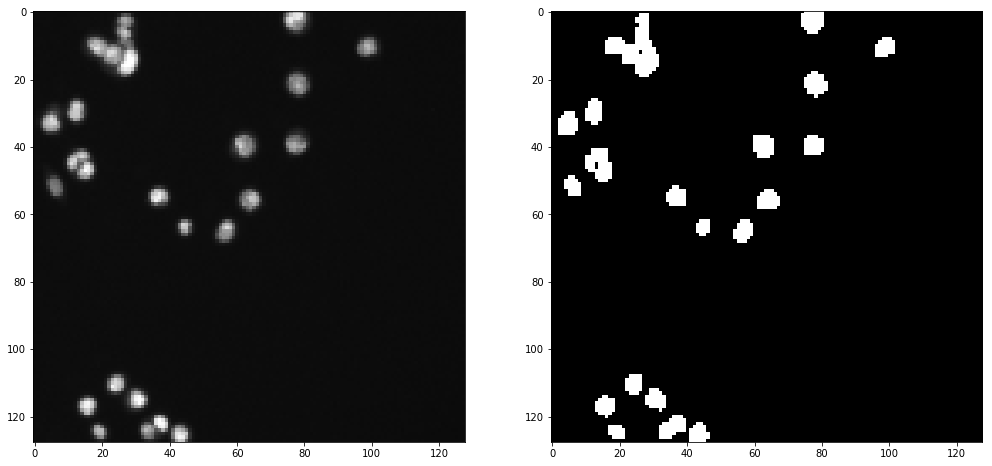

In [96]:
j = 15
plt.figure(figsize=(17, 10))
plt.subplot(1, 2, 1)
plt.imshow(X_train[j], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(Y_train[j][:,:,0], cmap='gray')

In [98]:
def flip_rotate(img):
    return (img, np.rot90(img,1), np.rot90(img,2), np.rot90(img,3), np.flipud(img), 
            np.rot90(np.flipud(img),1), np.rot90(np.flipud(img),2), np.rot90(np.flipud(img),3))

In [106]:
def augment(images,image_size):
    aug = 8
    imgs = np.zeros((len(images) * aug,image_size,image_size,3))
    for i in range(len(images)):
        add = aug*i
        (imgs[0+add,:,:,:],imgs[1+add,:,:,:],imgs[2+add,:,:,:],
         imgs[3+add,:,:,:],imgs[4+add,:,:,:], imgs[5+add,:,:,:],
         imgs[6+add,:,:,:],imgs[7+add,:,:,:]) = flip_rotate(images[i])
    return imgs

In [127]:
imgs = augment(X_train,128)

In [112]:
rotated = flip_rotate(X_train[j])[1]

In [117]:
imgs = np.zeros((8,128,128,3))

In [118]:
imgs[0,:,:,:] = rotated

In [119]:
add =0
(imgs[0+add,:,:,:],imgs[1+add,:,:,:],imgs[2+add,:,:,:],
         imgs[3+add,:,:,:],imgs[4+add,:,:,:], imgs[5+add,:,:,:],
         imgs[6+add,:,:,:],imgs[7+add,:,:,:]) = flip_rotate(X_train[j])

In [125]:
images = X_train
aug = 8
imgs = np.zeros((len(images) * aug,128,128,3))
for i in range(len(images)):
    add = aug*i
    (imgs[0+add,:,:,:],imgs[1+add,:,:,:],imgs[2+add,:,:,:],
     imgs[3+add,:,:,:],imgs[4+add,:,:,:], imgs[5+add,:,:,:],
     imgs[6+add,:,:,:],imgs[7+add,:,:,:]) = flip_rotate(images[i])

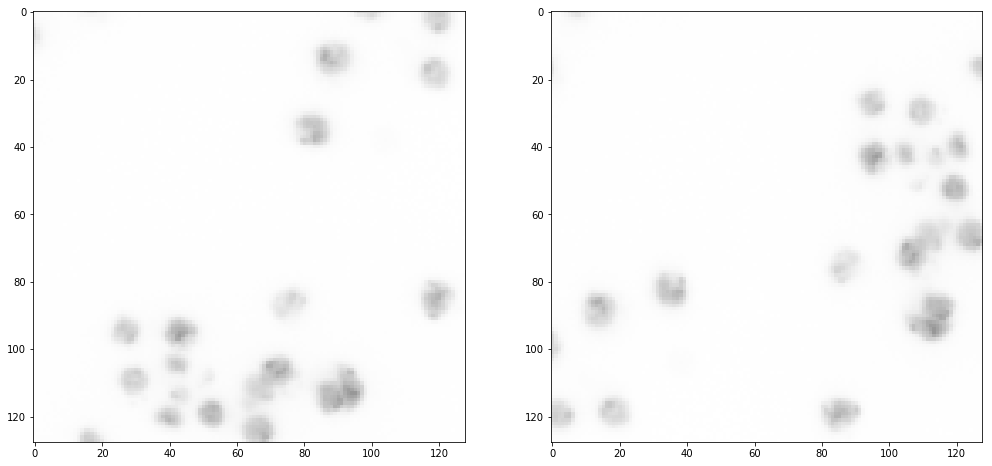

In [128]:
j = 15
plt.figure(figsize=(17, 10))
plt.subplot(1, 2, 1)
plt.imshow(imgs[j,:,:,:], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(imgs[j,:,:,:], cmap='gray')

In [26]:
y = np.expand_dims(x, axis=0)
print(y.shape)
y

(1, 2)
[[1 2]]


array([[1, 2]])

In [34]:
path = TRAIN_PATH + '00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552'
print(path)
asd = next(os.walk(path + '/masks/'))[2]

/Users/enricofonda/Data_science/DSBowl2018/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552


['07a9bf1d7594af2763c86e93f05d22c4d5181353c6d3ab30a345b908ffe5aadc.png',
 '0e548d0af63ab451616f082eb56bde13eb71f73dfda92a03fbe88ad42ebb4881.png',
 '0ea1f9e30124e4aef1407af239ff42fd6f5753c09b4c5cac5d08023c328d7f05.png',
 '0f5a3252d05ecdf453bdd5e6ad5322c454d8ec2d13ef0f0bf45a6f6db45b5639.png',
 '2c47735510ef91a11fde42b317829cee5fc04d05a797b90008803d7151951d58.png',
 '4afa39f2a05f9884a5ff030d678c6142379f99a5baaf4f1ba7835a639cb50751.png',
 '4bc58dbdefb2777392361d8b2d686b1cc14ca310e009b79763af46e853e6c6ac.png',
 '4e3b49fb14877b63704881a923365b68c1def111c58f23c66daa49fef4b632bf.png',
 '5522143fa8723b66b1e0b25331047e6ae6eeec664f7c8abeba687e0de0f9060a.png',
 '58656859fb9c13741eda9bc753c3415b78d1135ee852a194944dee88ab70acf4.png',
 '6442251746caac8fc255e6a22b41282ffcfabebadbd240ee0b604808ff9e3383.png',
 '7ff04129f8b6d9aaf47e062eadce8b3fcff8b4a29ec5ad92bca926ac2b7263d2.png',
 '8bbec3052bcec900455e8c7728d03facb46c880334bcc4fb0d1d066dd6c7c5d2.png',
 '9576fe25f4a510f12eecbabfa2e0237b98d8c2622b9e13b9a

In [36]:
next(os.walk(path + '/masks/'))[2][1:3]

['0e548d0af63ab451616f082eb56bde13eb71f73dfda92a03fbe88ad42ebb4881.png',
 '0ea1f9e30124e4aef1407af239ff42fd6f5753c09b4c5cac5d08023c328d7f05.png']

In [45]:
mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
for mask_file in next(os.walk(path + '/masks/'))[2][0:5]:
    mask_ = imread(path + '/masks/' + mask_file)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                  preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)

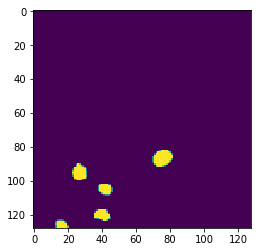

In [46]:
im = plt.imshow(mask[:,:,0])
plt.show()

In [2]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [3]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [168]:
# Fit model
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=10, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/10
603/603 [==============================] - 278s - loss: 0.0826 - mean_iou: 0.7910 - val_loss: 0.0901 - val_mean_iou: 0.7933
Epoch 2/10
603/603 [==============================] - 289s - loss: 0.0794 - mean_iou: 0.7955 - val_loss: 0.0997 - val_mean_iou: 0.7977
Epoch 3/10
603/603 [==============================] - 311s - loss: 0.0822 - mean_iou: 0.7995 - val_loss: 0.0790 - val_mean_iou: 0.8014
Epoch 4/10
603/603 [==============================] - 313s - loss: 0.0774 - mean_iou: 0.8031 - val_loss: 0.0875 - val_mean_iou: 0.8048
Epoch 5/10
603/603 [==============================] - 296s - loss: 0.0754 - mean_iou: 0.8064 - val_loss: 0.0814 - val_mean_iou: 0.8078
Epoch 6/10
603/603 [==============================] - 313s - loss: 0.0803 - mean_iou: 0.8093 - val_loss: 0.0852 - val_mean_iou: 0.8106
Epoch 7/10
603/603 [==============================] - 311s - loss: 0.0739 - mean_iou: 0.8119 - val_loss: 0.0788 - val_mean_iou: 0.8133
Epoch 8/10

In [169]:
# Predict on train, val and test
# model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)



65/65 [==============================] - 13s    


In [171]:
model.save('DSB2018-2.h5')

In [5]:
model = load_model('DSB2018-2.h5', custom_objects={'mean_iou': mean_iou})

/Users/enricofonda/anaconda/lib/python3.5/site-packages/keras/models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [12]:
preds_test = model.predict(X_test, verbose=1)

65/65 [==============================] - 18s 282ms/step


In [58]:
print(X_train.shape)
print(preds_train.shape)
print(preds_val.shape)
print(preds_test.shape)
print(len(preds_test))

(670, 128, 128, 3)
(603, 128, 128, 1)
(67, 128, 128, 1)
(65, 128, 128, 1)
65


In [59]:
sizes_test

[[256, 256],
 [519, 253],
 [256, 256],
 [256, 256],
 [256, 256],
 [512, 680],
 [512, 640],
 [512, 680],
 [512, 640],
 [256, 256],
 [519, 162],
 [512, 640],
 [524, 348],
 [256, 256],
 [512, 680],
 [256, 256],
 [256, 256],
 [519, 253],
 [256, 256],
 [524, 348],
 [520, 348],
 [260, 347],
 [512, 680],
 [256, 256],
 [512, 680],
 [256, 256],
 [390, 239],
 [512, 640],
 [256, 256],
 [256, 256],
 [260, 347],
 [256, 256],
 [520, 348],
 [512, 640],
 [256, 256],
 [256, 256],
 [260, 347],
 [520, 348],
 [512, 640],
 [256, 256],
 [512, 640],
 [520, 696],
 [256, 256],
 [512, 640],
 [512, 680],
 [519, 253],
 [519, 161],
 [256, 256],
 [520, 696],
 [524, 348],
 [520, 696],
 [524, 348],
 [519, 161],
 [519, 162],
 [520, 348],
 [256, 256],
 [512, 680],
 [256, 256],
 [260, 347],
 [256, 256],
 [519, 253],
 [520, 696],
 [512, 680],
 [256, 256],
 [256, 256]]

In [13]:
# Threshold predictions
# preds_train_t = (preds_train > 0.5).astype(np.uint8)
# preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [66]:
test_ids[0:10]

['0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5',
 '0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac',
 '0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732',
 '0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925',
 '0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6',
 '0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466',
 '1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c',
 '17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff',
 '1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b',
 '191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829']

In [165]:
for n, id_ in enumerate(test_ids[0:10]): # len(test_ids)
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    print(id_)
    print(img.shape)

0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5
(256, 256, 3)
0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac
(519, 253, 3)
0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732
(256, 256, 3)
0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925
(256, 256, 3)
0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6
(256, 256, 3)
0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466
(512, 680, 3)
1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c
(512, 640, 3)
17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff
(512, 680, 3)
1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b
(512, 640, 3)
191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829
(256, 256, 3)


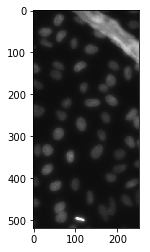

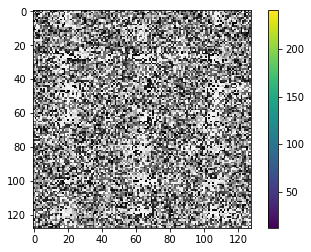

In [95]:
path = TEST_PATH + '0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac'
img = imread(path + '/images/' + '0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac' + '.png')[:,:,:IMG_CHANNELS]
sizes_test.append([img.shape[0], img.shape[1]])
im = plt.imshow(img)
plt.show()

imgt = resize(img,(128,128), mode='constant')#resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
imgt = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

im = plt.imshow(imgt)
plt.colorbar()
plt.show()

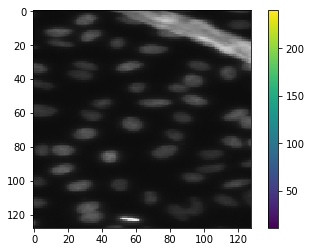

In [93]:
im = plt.imshow(X_test[1])
plt.colorbar()
plt.show()

In [120]:
img[0:2][1][1]

array([ 16.75,  16.75,  16.75])

In [121]:
X_test[0][1][1]

array([3, 3, 3], dtype=uint8)

In [118]:
imgt[0:2][1][1]

array([ 20.1171875,  20.1171875,  20.1171875])

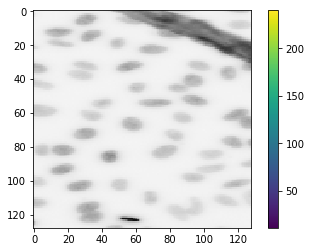

In [103]:
im = plt.imshow(np.floor(imgt))
plt.colorbar()
plt.show()

In [116]:
np.floor(imgt)[0:2][1][1]

array([ 20.,  20.,  20.])

In [104]:
imgtt = np.zeros(( IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [105]:
imgtt = imgt

In [117]:
imgtt[0:2][1][1]

array([ 20.1171875,  20.1171875,  20.1171875])

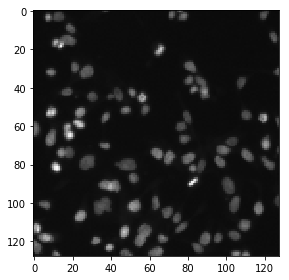

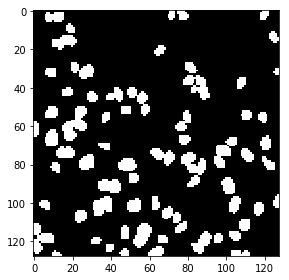

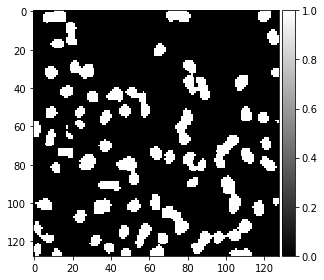

In [143]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]), cmap='gray')
plt.show()

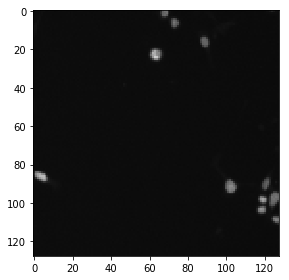

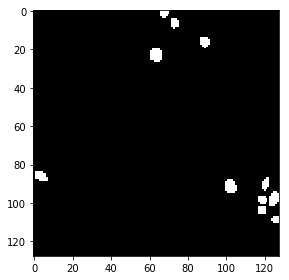

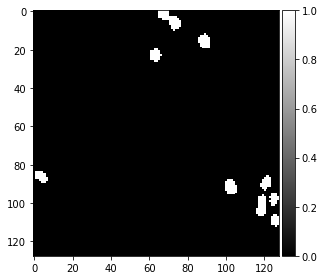

In [144]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]), cmap='gray')
plt.show()

In [15]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [16]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [17]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-new.csv', index=False)

In [181]:
filename = PATH + 'data_train2.hdf5'
h = h5py.File(filename, 'w')
dset = h.create_dataset('data', data=X_train)
h.close()

In [182]:
filename = PATH + 'data_train_Y.hdf5'
h = h5py.File(filename, 'w')
dset = h.create_dataset('data', data=Y_train)
h.close()

In [183]:
filename = PATH + 'data_test.hdf5'
h = h5py.File(filename, 'w')
dset = h.create_dataset('data', data=X_test)
h.close()

In [185]:
filename = PATH + 'sizes_test.hdf5'
h = h5py.File(filename, 'w')
dset = h.create_dataset('data', data=sizes_test)
h.close()

In [ ]:
filename = PATH + 'test_ids.hdf5'
h = h5py.File(filename, 'w')
dset = h.create_dataset('data', data=test_ids)
h.close()